In [1]:
#!/usr/bin/env python3
# Importing all required dependencies
import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.labelsize'] : 20
import scipy.special as sp
import nlopt
from scipy.stats import norm, chi2, uniform
from scipy.interpolate import UnivariateSpline

In [2]:
def model(L, Delta, T, Ub, a):
    # Number of mesh points on domain -L < x < L with uniform mesh spacing Delta
    N = int(2 * L / Delta) + 1
    # Vectorize xloc generation: This creates the xloc array directly
    xloc = np.linspace(-L, L, N)
    # Precompute sqrt(4 * a[2] * T) once
    sqrt_term = np.sqrt(4 * a[2] * T)
    # Vectorized calculation of the exact solution c(x)
    term1 = (a[1] - (xloc - a[3] * T)) / sqrt_term
    term2 = (a[1] + (xloc - a[3] * T)) / sqrt_term
    # Calculate the concentration using vectorized error function calculations
    y = Ub + a[0] * (sp.erf(term1) + sp.erf(term2)) / 2
    return y

### Process model for density $u(x,t) \ge 0$

\begin{equation*}
\large{\dfrac{\partial u}{\partial t} = D \dfrac{\partial^2 u}{\partial x^2} - v \dfrac{\partial u}{\partial x} } 
\end{equation*}

### Initial condition

\begin{align*}
\large{u(x,0)} &\large{= u_b,} \quad \large{ |x| > h}, \notag \\
\large{u(x,0)} &\large{= u_b+u_0,} \quad \large{ |x| < h,} \notag \\
\end{align*}

### Exact solution

\begin{equation*}
\large{u(x,t) =  u_b + \dfrac{u_0}{2}\left[\textrm{erf}\left(\dfrac{h-(x-vt)}{2\sqrt{Dt}}\right)+\textrm{erf}\left(\dfrac{h+(x-vt)}{2\sqrt{Dt}}\right)  \right]},
\end{equation*}

### Parameters

\begin{equation*}
\large{\theta = (u_0,h,D,v)^\top}.
\end{equation*}

In [3]:
def loglhood(data, a, Ub, L, Delta, T, xloc, sigma):
    # Evaluate the model solution with parameters a = [U0, h, D, v]
    y = model(L, Delta, T, Ub, a)
    
    # Vectorized calculation of the log-likelihood
    diff = data - y  # Compute the difference between data and model
    log_likelihood = np.sum(norm.logpdf(diff, loc=0, scale=sigma))  # Compute logpdf for all differences at once
    
    return log_likelihood

## Noise model: Additive Gaussian


\begin{equation*}
\large{u^\textrm{obs}(x,t) \mid \theta = \mathcal{N}\left(u(x,t), \sigma^2\right)},
\end{equation*}

## Log-likelihood function

\begin{equation*}
	\large{\ell(\theta \mid u^\textrm{obs}(x_i,t)) = \sum_{i=1}^{I} \log \left[\phi\left(u^\textrm{obs}(x_i,t); u(x_i,t), \sigma^2 \right)\right]}.
\end{equation*}

where $\phi(x; \mu, \sigma^2)$ denotes the probability density function of the normal distribution with mean $\mu$, variance $\sigma^2$.

In [4]:
a = np.zeros(4)  # a=zeros(4)
def funmle(a):
    # function to optimize for the MLE, this function returns the log-likelihood for the vector of parameters a = (U0, h, D, v)
    return loglhood(data, a, Ub, L, Delta, T, xloc, sigma)

In [5]:
def Optimise(fun, theta0, lb, ub):
    # Optimize finds the values of parameters theta that maximise the objective function fun with lower bounds lb, and upper bounds ub
    # In Julia: tomax=(θ,∂θ)->fun(θ)
    # In Python NLopt minimizes the objective so we define an objective that returns -fun(theta)
    def objective(theta, grad):
        return -fun(theta)
    opt = nlopt.opt(nlopt.LN_NELDERMEAD, len(theta0))
    opt.set_min_objective(objective)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    # Set maximum time in seconds (maxtime in Julia)
    opt.set_maxtime(60)
    xopt = opt.optimize(np.array(theta0))
    # In NLopt, the result returned by optimization is the minimizer of the negative objective.
    fopt = -opt.last_optimum_value()
    return xopt, fopt

In [6]:
# Set up parameters and discretisation
L = 200  # set up the domain -200< x < 200, discretised with mesh spacing Delta
Delta = 5
N = int(2 * L / Delta) + 1
xloc = np.zeros(N)
for i in range(1, N+1):
    xloc[i-1] = -L + (i - 1) * Delta

# Set parameter values
D = 10.0  
v = 1.0   
T = 50
Ub = 1.0
U0 = 1.0   
h = 50     
sigma = 1.0 / 20  

# Define functions f and g as in Julia
def f_func(x):
    return Ub

def g_func(x):
    return Ub + U0

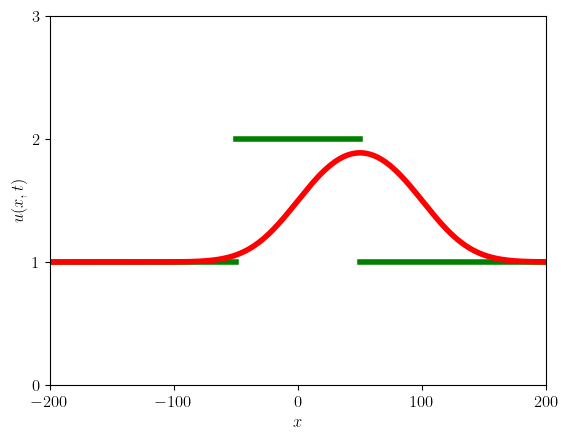

In [7]:
# Plot initial condition and solution at time T
x_plot_line = np.linspace(-L, L, 400)
# Create the first plot p1
fig1, ax1 = plt.subplots()
# Plot f from -L to -h
x_range1 = np.linspace(-L, -h, 200)
ax1.plot(x_range1, [f_func(x) for x in x_range1], lw=4, color='green', label='_nolegend_')
# Plot f from h to L
x_range2 = np.linspace(h, L, 200)
ax1.plot(x_range2, [f_func(x) for x in x_range2], lw=4, color='green', label='_nolegend_')
# Plot g from -h to h
x_range3 = np.linspace(-h, h, 200)
ax1.plot(x_range3, [g_func(x) for x in x_range3], lw=4, color='green', label='_nolegend_')
# Define u(x)= Ub+U0*(erf((h-(x-v*T))/sqrt(4*D*T))+erf((h+(x-v*T))/sqrt(4*D*T)))/2;
def u(x):
    return Ub + U0 * (sp.erf((h - (x - v * T)) / np.sqrt(4 * D * T)) + sp.erf((h + (x - v * T)) / np.sqrt(4 * D * T))) / 2
ax1.plot(x_plot_line, [u(x) for x in x_plot_line], lw=4, color='red', label='_nolegend_')
ax1.set_xlabel(r"$x$",fontsize=12)
ax1.set_ylabel(r"$u(x,t)$",fontsize=12)
ax1.set_xlim(-L, L)
ax1.set_ylim(0, 3)
ax1.set_xticks([-200, -100, 0, 100, 200])
ax1.set_xticklabels([r"$-200$", r"$-100$", r"$0$", r"$100$", r"$200$"],fontsize=12)
ax1.set_yticks([0, 1, 2, 3])
ax1.set_yticklabels([r"$0$", r"$1$", r"$2$", r"$3$"],fontsize=12)
ax1.tick_params(labelsize=12)

In [8]:
# Data: Fixed data generated by solving the process model and corrupting the solution with additive Gaussian noise with sigma=0.05 
data = np.array([1.0746704200035107,
0.9997809477379822,
0.9757424595863007,
0.9818892671248993,
0.9417708005709577,
0.969002076526583,
0.9913160637355931,
0.8878038515243347,
1.0198197226589736,
0.9974211828246098,
1.0805146205871154,
0.9161679919462387,
0.970326879443432,
1.0140484393549576,
1.0673792764518402,
0.9976045065683884,
1.0166341446161276,
0.966794550221958,
1.033060780390708,
1.0297279162356239,
1.0421637035845757,
0.9544610289017758,
0.9420581661953022,
1.017640239352237,
1.0118294479532317,
1.0241821081772111,
0.9931867276558649,
1.0546221441690116,
0.9642581479921727,
1.0589964208816462,
1.1273046234492679,
1.0690098332703886,
1.1524384816738436,
1.1697400806858214,
1.1622237579309098,
1.1390886574429542,
1.2623805416775193,
1.2589102881916183,
1.3393589749927486,
1.4953486013403088,
1.4843625102318858,
1.529199284923832,
1.6056104756265166,
1.639104867809398,
1.6595888873078761,
1.7630697196896132,
1.835615768375447,
1.7765843614827102,
1.8697454780507807,
1.8847084582262323,
1.8523664988882582,
1.8009396841570668,
1.8556831916925527,
1.8510050281633894,
1.746972155093142,
1.7272026936725604,
1.7594774530389148,
1.6630295292350292,
1.692035779430916,
1.564052552272523,
1.5078371058254056,
1.4970973352354653,
1.4120496033555034,
1.3472843464970161,
1.314020409248756,
1.1666589798192746,
1.1889172748718695,
1.091453675175676,
1.0926213080628115,
1.1338847541310328,
0.9763923651812882,
1.0051032221514438,
0.9910155981953401,
1.0317336419556944,
0.9851394734351673,
0.9884599389317271,
1.0908678764438349,
1.0331338603532612,
1.1004696243222967,
1.087821055397088,
0.9327167483496567]);

Optimization time: 0.0331 seconds


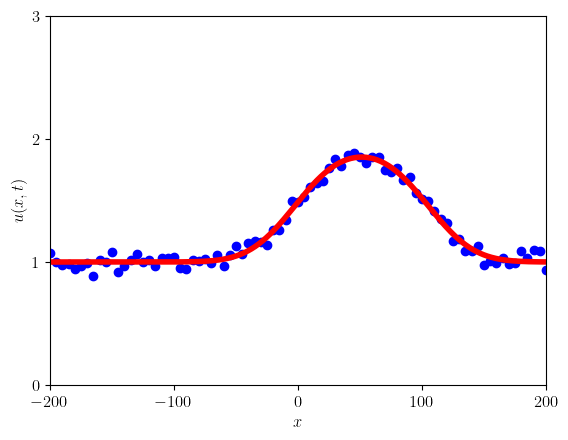

In [9]:
thetaG = [1.0, 45, 5, 1]  # Initial parameter estimates for the iterative optimization solver
lb = [0, 0, 0.01, -10]    # lower bounds
ub = [10, L, 100, 10]      # upper bounds

# Timing the optimization as in Julia: @time (xopt,fopt)=Optimise(funmle,θG,lb,ub)
start_time = time.time()
xopt, fopt = Optimise(funmle, thetaG, lb, ub)
print("Optimization time: {:.4f} seconds".format(time.time() - start_time))

U0mle = xopt[0]  # Store MLE
hmle = xopt[1]   # Store MLE
Dmle = xopt[2]   # Store MLE
vmle = xopt[3]   # Store MLE
fmle = fopt      # Store log-likelihood value at the MLE

# MLE solution: umle(x)=Ub+U0mle*(erf((hmle-(x-vmle*T))/sqrt(4*Dmle*T))+erf((hmle+(x-vmle*T))/sqrt(4*Dmle*T)))/2;
def umle(x):
    return Ub + U0mle * (sp.erf((hmle - (x - vmle * T)) / np.sqrt(4 * Dmle * T)) \
           + sp.erf((hmle + (x - vmle * T)) / np.sqrt(4 * Dmle * T))) / 2

# Plotting the data and MLE solution
fig2, ax2 = plt.subplots()
ax2.scatter(xloc, data, color='blue', label='_nolegend_')
ax2.plot(x_plot_line, [umle(x) for x in x_plot_line], lw=4, color='red', label='_nolegend_')
ax2.set_xlabel(r"$x$",fontsize=12)
ax2.set_ylabel(r"$u(x,t)$",fontsize=12)
ax2.set_xlim(-L, L)
ax2.set_ylim(0, U0 + Ub + 0.1)
ax2.set_xticks([-200, -100, 0, 100, 200])
ax2.set_xticklabels([r"$-200$", r"$-100$", r"$0$", r"$100$", r"$200$"],fontsize=12)
ax2.set_yticks([0, 1, 2, 3])
ax2.set_yticklabels([r"$0$", r"$1$", r"$2$", r"$3$"],fontsize=12)
ax2.tick_params(labelsize=12)

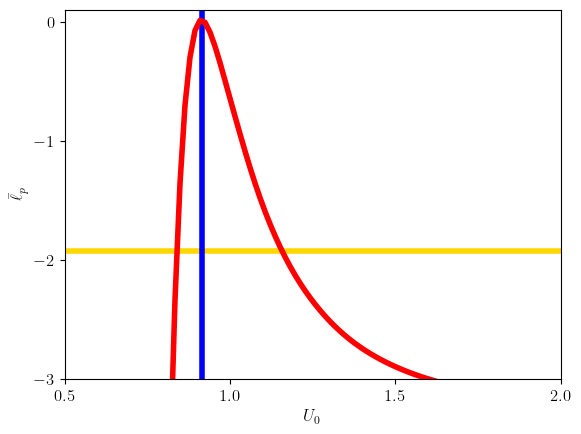

In [14]:
# Set degrees of freedom for the asymptotic threshold value for the univariate profile likelihood
df = 1  # degrees of freedom
llstar = -chi2.ppf(0.95, df) / 2  # log-likelihood threshold for the 95% threshold

def univariateU0(U0_val):
    a_local = np.zeros(3)
    def funU0(a_nuisance):
        # Evaluate the log-likelihood at a specified value U0
        a_full = np.array([U0_val, a_nuisance[0], a_nuisance[1], a_nuisance[2]])
        return loglhood(data, a_full, Ub, L, Delta, T, xloc, sigma)
    thetaG_local = [hmle, Dmle, vmle]  # Estimate of the nuisance parameters h, D, v
    lb_local = [0, 0.01, 0]  # Lower bounds for nuisance parameters h, D, v
    ub_local = [L, 1000, 100]  # Upper bounds for nuisance parameters h, D, v
    xopt_local, fopt_local = Optimise(funU0, thetaG_local, lb_local, ub_local)
    return fopt_local, xopt_local  # Return the profile log-likelihood and value of the nuisance parameter

def f_profile_U0(x):
    return univariateU0(x)[0]

M = 100  # Take a grid of M points to plot the univariate profile likelihood
U0range = np.linspace(0.5, 2.0, M)
ff = np.zeros(M)
for i in range(M):
    ff[i] = univariateU0(U0range[i])[0]  # Compute the profile log-likelihood over the M mesh points
#Plot the normalised profile log-likelihood for U0, superimposed with the MLE and 95% threshold 
fig4, ax4 = plt.subplots()
ax4.axhline(llstar, lw=4, color='gold', label='_nolegend_')
ax4.axvline(U0mle, lw=4, color='blue', label='_nolegend_')
#Spline1D: using UnivariateSpline with specified smoothing factor s and degree k=3
spl = UnivariateSpline(U0range, ff - np.max(ff), k=3, s=0.0005)
yy = spl(U0range)
ax4.plot(U0range, yy, lw=4, color='red')
ax4.set_ylim(-3, 0.1)
ax4.set_xlim(U0range[0], U0range[-1])
ax4.set_xticks([0.5, 1.0, 1.5, 2.0])
ax4.set_xticklabels([r"$0.5$", r"$1.0$", r"$1.5$", r"$2.0$"],fontsize=12)
ax4.set_yticks([-3, -2, -1, 0])
ax4.set_yticklabels([r"$-3$", r"$-2$", r"$-1$", r"$0$"],fontsize=12)
ax4.tick_params(labelsize=12)
ax4.set_xlabel(r"$U_0$",fontsize=12)
ax4.set_ylabel(r"$\bar{\ell}_p$",fontsize=12);

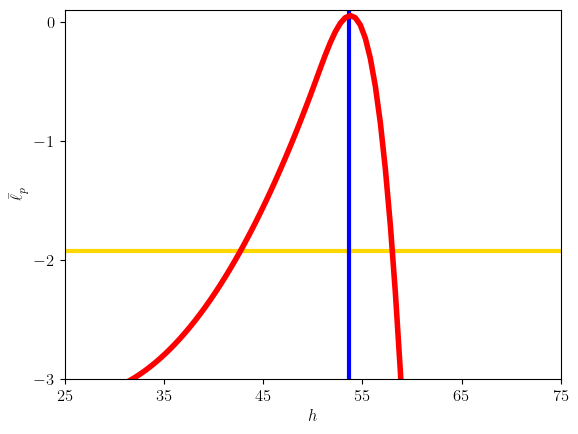

In [15]:
def univariateh(h_val):
    a_local = np.zeros(3)
    def funh(a_nuisance):
        # Evaluate the log-likelihood at a specified value h
        a_full = np.array([a_nuisance[0], h_val, a_nuisance[1], a_nuisance[2]])
        return loglhood(data, a_full, Ub, L, Delta, T, xloc, sigma)
    thetaG_local = [U0mle, Dmle, vmle]  # Estimate of the nuisance parameters U0, D, v
    lb_local = [0, 0.01, 0]  # Lower bounds for the nuisance parameters U0, D, v
    ub_local = [100, 1000, 100]  # Upper bounds for the nuisance parameters U0, D, v
    xopt_local, fopt_local = Optimise(funh, thetaG_local, lb_local, ub_local)
    return fopt_local, xopt_local  # Return the profile log-likelihood and value of the nuisance parameter

def f_profile_h(x):
    return univariateh(x)[0]

M = 100  # Take a grid of M points to plot the univariate profile likelihood
hrange = np.linspace(25, 75, M)
ff_h = np.zeros(M)
for i in range(M):
    ff_h[i] = univariateh(hrange[i])[0]  # Compute the profile log-likelihood over the M mesh points

# Plot the normalised profile log-likelihood for h, superimposed with the MLE and 95% threshold
fig5, ax5 = plt.subplots()
ax5.axhline(llstar, lw=3, color='gold', label='_nolegend_')
ax5.axvline(hmle, lw=3, color='blue', label='_nolegend_')
spl_h = UnivariateSpline(hrange, ff_h - np.max(ff_h), k=3, s=0.1)
yy_h = spl_h(hrange)
ax5.plot(hrange, yy_h, lw=4, color='red')
ax5.set_ylim(-3, 0.1)
ax5.set_xlim(hrange[0], hrange[-1])
ax5.set_xticks([25, 35, 45, 55, 65, 75])
ax5.set_xticklabels([r"$25$", r"$35$", r"$45$", r"$55$", r"$65$", r"$75$"],fontsize=12)
ax5.set_yticks([-3, -2, -1, 0])
ax5.set_yticklabels([r"$-3$", r"$-2$", r"$-1$", r"$0$"],fontsize=12)
ax5.tick_params(labelsize=12)
ax5.set_xlabel(r"$h$",fontsize=12)
ax5.set_ylabel(r"$\bar{\ell}_p$",fontsize=12);

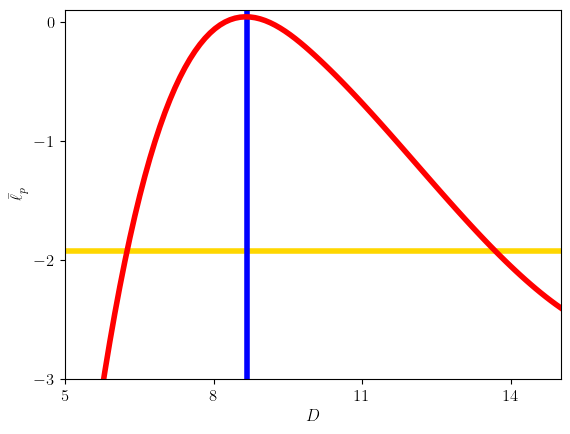

In [16]:
def univariateD(D_val):
    a_local = np.zeros(3)
    def funD(a_nuisance):
        # Evaluate the log-likelihood at a specified value D
        a_full = np.array([a_nuisance[0], a_nuisance[1], D_val, a_nuisance[2]])
        return loglhood(data, a_full, Ub, L, Delta, T, xloc, sigma)
    thetaG_local = [U0mle, hmle, vmle]  # Estimate of the nuisance parameters U0, h, v
    lb_local = [0, 0, 0]  # Lower bounds for the nuisance parameters U0, h, v
    ub_local = [100, L, 100]  # Upper bounds for the nuisance parameters U0, h, v
    xopt_local, fopt_local = Optimise(funD, thetaG_local, lb_local, ub_local)
    return fopt_local, xopt_local  # Return the profile log-likelihood and value of the nuisance parameter

def f_profile_D(x):
    return univariateD(x)[0]

M = 100  # Take a grid of M points to plot the univariate profile likelihood
Drange = np.linspace(5, 15, M)
ff_D = np.zeros(M)
for i in range(M):
    ff_D[i] = univariateD(Drange[i])[0]  # Compute the profile log-likelihood over the M mesh points

# Plot the normalised profile log-likelihood for D, superimposed with the MLE and 95% threshold
fig6, ax6 = plt.subplots()
ax6.axhline(llstar, lw=4, color="gold", label='_nolegend_')
ax6.axvline(Dmle, lw=4, color='blue', label='_nolegend_')
spl_D = UnivariateSpline(Drange, ff_D - np.max(ff_D), k=3, s=0.1)
yy_D = spl_D(Drange)
ax6.plot(Drange, yy_D, lw=4, color='red')
ax6.set_ylim(-3, 0.1)
ax6.set_xlim(Drange[0], Drange[-1])
ax6.set_xticks([5, 8, 11, 14])
ax6.set_xticklabels([r"$5$", r"$8$", r"$11$", r"$14$"],fontsize=12)
ax6.set_yticks([-3, -2, -1, 0])
ax6.set_yticklabels([r"$-3$", r"$-2$", r"$-1$", r"$0$"],fontsize=12)
ax6.tick_params(labelsize=12)
ax6.set_xlabel(r"$D$",fontsize=12)
ax6.set_ylabel(r"$\bar{\ell}_p$",fontsize=12);

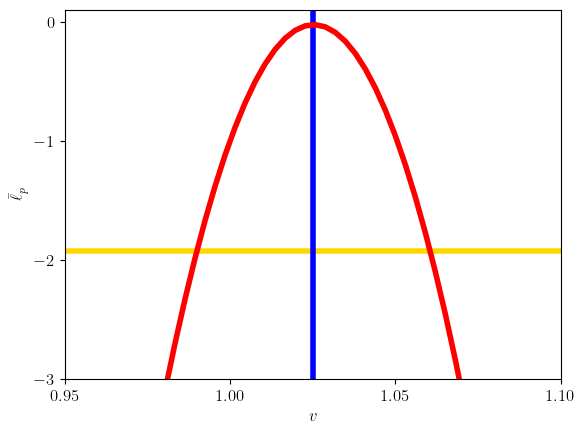

In [17]:
def univariatev(v_val):
    a_local = np.zeros(3)
    def funv(a_nuisance):
        # Evaluate the log-likelihood at a specified value v
        a_full = np.array([a_nuisance[0], a_nuisance[1], a_nuisance[2], v_val])
        return loglhood(data, a_full, Ub, L, Delta, T, xloc, sigma)
    thetaG_local = [U0mle, hmle, Dmle]  # Estimate of the nuisance parameters U0, h, D
    lb_local = [0, 0, 0.01]  # Lower bound of the nuisance parameters U0, h, D
    ub_local = [100, L, 1000]  # Upper bound of the nuisance parameters U0, h, D
    xopt_local, fopt_local = Optimise(funv, thetaG_local, lb_local, ub_local)
    return fopt_local, xopt_local  # Return the profile log-likelihood and value of the nuisance parameter

def f_profile_v(x):
    return univariatev(x)[0]

M = 100  # Take a grid of M points to plot the univariate profile likelihood
vrange = np.linspace(0.85, 1.15, M)
ff_v = np.zeros(M)
for i in range(M):
    ff_v[i] = univariatev(vrange[i])[0]  # Compute the profile log-likelihood over the M mesh points

# Plot the normalised profile log-likelihood for v, superimposed with the MLE and 95% threshold
fig7, ax7 = plt.subplots()
ax7.axhline(llstar, lw=4, color='gold', label='_nolegend_')
ax7.axvline(vmle, lw=4, color='blue', label='_nolegend_')
spl_v = UnivariateSpline(vrange, ff_v - np.max(ff_v), k=3, s=0.1)
yy_v = spl_v(vrange)
ax7.plot(vrange, yy_v, lw=4, color='red')
ax7.set_ylim(-3, 0.1)
ax7.set_xlim(0.95,1.05)
ax7.set_xticks([0.95, 1.00, 1.05, 1.10])
ax7.set_xticklabels([r"$0.95$", r"$1.00$", r"$1.05$", r"$1.10$"],fontsize=12)
ax7.set_yticks([-3, -2, -1, 0])
ax7.set_yticklabels([r"$-3$", r"$-2$", r"$-1$", r"$0$"],fontsize=12)
ax7.tick_params(labelsize=12)
ax7.set_xlabel(r"$v$",fontsize=12)
ax7.set_ylabel(r"$\bar{\ell}_p$",fontsize=12);

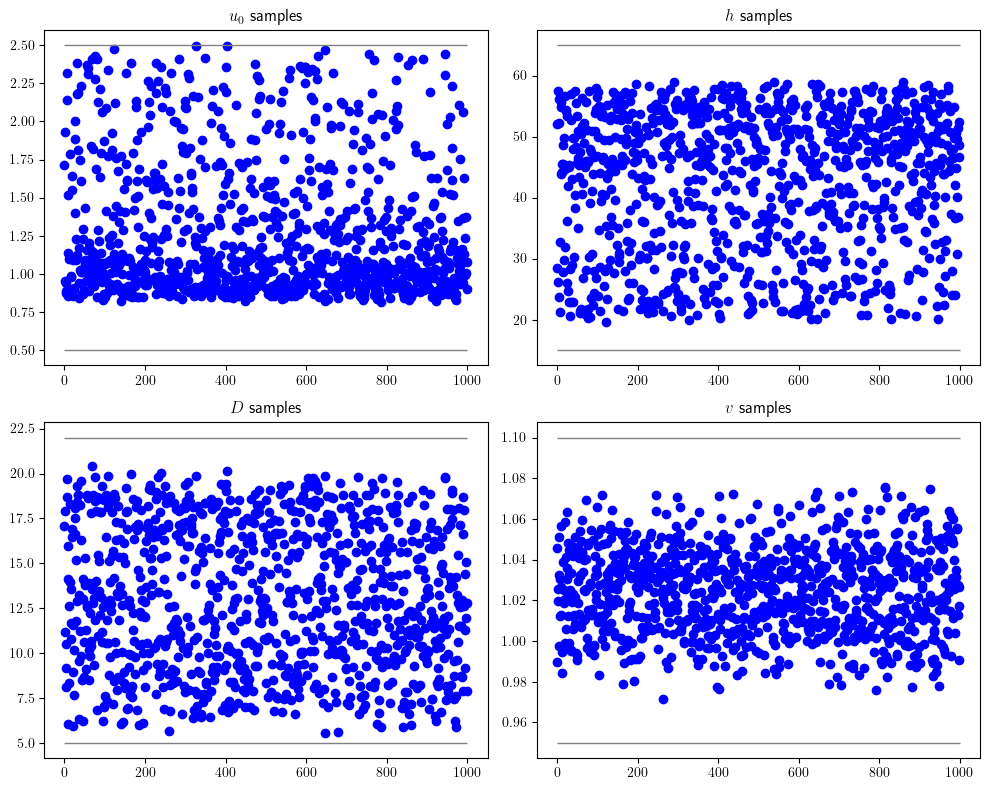

In [26]:
# Define simple bounds on each parameter space
U0min=0.5; U0max=2.5;
hmin=15; hmax=65;
Dmin=5; Dmax=22;
vmin=0.95; vmax=1.1; 

df = 4  # degrees of freedom for the asymptotic threshold value
llstar = -chi2.ppf(0.95, df) / 2  # log-likelihood threshold for the 95% threshold

M_samples = 1000  # Number of samples to be drawn
Usampled = np.zeros(M_samples)
hsampled = np.zeros(M_samples)
Dsampled = np.zeros(M_samples)
vsampled = np.zeros(M_samples)
lls = np.zeros(M_samples)
kount = 0

# Sampling loop: rejection sampling based on the log-likelihood threshold
while kount < M_samples:
    U0g = uniform.rvs(loc=U0min, scale=U0max - U0min)  # Draw a random sample of U0
    hg = uniform.rvs(loc=hmin, scale=hmax - hmin)         # Draw a random sample of h
    Dg = uniform.rvs(loc=Dmin, scale=Dmax - Dmin)          # Draw a random sample of D
    vg = uniform.rvs(loc=vmin, scale=vmax - vmin)          # Draw a random sample of v
    if (loglhood(data, np.array([U0g, hg, Dg, vg]), Ub, L, Delta, T, xloc, sigma) - fmle) >= llstar:
        lls[kount] = loglhood(data, np.array([U0g, hg, Dg, vg]), Ub, L, Delta, T, xloc, sigma) - fmle
        Usampled[kount] = U0g
        hsampled[kount] = hg
        Dsampled[kount] = Dg
        vsampled[kount] = vg
        kount += 1
        

# Plot samples of each parameter
fig9, axs9 = plt.subplots(2, 2, figsize=(10,8))
axs9[0,0].scatter(range(M_samples),Usampled, color='blue')
axs9[0,0].hlines([U0min,U0max], xmin=0, xmax=M_samples, color='gray', linewidth=1)
axs9[0,0].set_title(r"$u_0$ samples",fontsize=12)
axs9[0,1].scatter(range(M_samples),hsampled, color='blue')
axs9[0,1].hlines([hmin,hmax], xmin=0, xmax=M_samples, color='gray', linewidth=1)
axs9[0,1].set_title(r"$h$ samples",fontsize=12)
axs9[1,0].scatter(range(M_samples),Dsampled, color='blue')
axs9[1,0].hlines([Dmin,Dmax], xmin=0, xmax=M_samples, color='gray', linewidth=1)
axs9[1,0].set_title(r"$D$ samples",fontsize=12)
axs9[1,1].scatter(range(M_samples),vsampled, color='blue')
axs9[1,1].hlines([vmin,vmax], xmin=0, xmax=M_samples, color='gray', linewidth=1)
axs9[1,1].set_title(r"$v$ samples",fontsize=12)
plt.tight_layout()

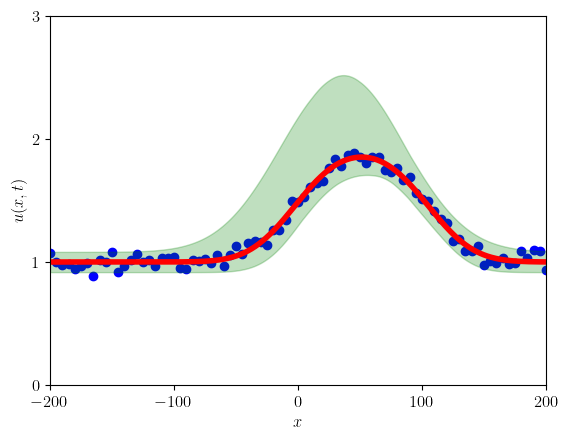

In [27]:
Delta_f = 1
Nf = int(2 * L / Delta_f) + 1
xlocf = np.zeros(Nf)
for i in range(1, Nf+1):
    xlocf[i-1] = -L + (i - 1) * Delta_f
# Set up a fine discretisation of -L < x < L with mesh spacing Delta_f for the prediction interval

lower_bound = 2 * (U0 + Ub) * np.ones(len(xlocf))  # Define vector on the fine spatial discretisation that will store the lower limit of the prediction interval
upper_bound = np.zeros(len(xlocf))                   # Define vector on the fine spatial discretisation that will store the upper limit of the prediction interval

# For each parameter sample solve the process model and update prediction intervals
for i in range(M_samples):
    # For each parameter sample, define C(x)
    def C(x, U0g=Usampled[i], hg=hsampled[i], Dg=Dsampled[i], vg=vsampled[i]):
        # Note: second erf uses the global h as in the original code
        return Ub + U0g * (sp.erf((hg - (x - vg * T)) / np.sqrt(4 * Dg * T)) \
               + sp.erf((h + (x - vg * T)) / np.sqrt(4 * Dg * T))) / 2
    for j in range(len(xlocf)):
        c_val = C(xlocf[j])
        # For each location across the domain compute the lower bound of the noise model
        lower_noise = c_val + norm.ppf(0.05, loc=0, scale=sigma)
        if lower_noise < lower_bound[j]:
            lower_bound[j] = lower_noise  # store the lower bound
        # For each location across the domain compute the upper bound of the noise model
        upper_noise = c_val + norm.ppf(0.95, loc=0, scale=sigma)
        if upper_noise > upper_bound[j]:
            upper_bound[j] = upper_noise  # store the upper bound

# Plot the data, MLE solution and prediction intervals
fig10, ax10 = plt.subplots()
ax10.scatter(xloc, data, color='blue', label='_nolegend_')
ax10.plot(x_plot_line, [umle(x) for x in x_plot_line], lw=4, color='red', label='_nolegend_')
ax10.set_xlabel(r"$x$",fontsize=12)
ax10.set_ylabel(r"$u(x,t)$",fontsize=12)
ax10.set_xlim(-L, L)
ax10.set_ylim(0, U0 + Ub + 0.1)
ax10.set_xticks([-200, -100, 0, 100, 200])
ax10.set_xticklabels([r"$-200$", r"$-100$", r"$0$", r"$100$", r"$200$"],fontsize=12)
ax10.set_yticks([0, 1, 2, 3])
ax10.set_yticklabels([r"$0$", r"$1$", r"$2$", r"$3$"],fontsize=12)
ax10.tick_params(labelsize=12)
# Plot the region that lies between the lower and upper bounds of the prediction intervals
ax10.plot(xlocf, lower_bound, lw=0, color='green')
ax10.fill_between(xlocf, lower_bound, upper_bound, color='green', alpha=0.25);